#Dự án nghiên cứu - Boat Listing Survey
**Mục tiêu của dự án**
1. Xậy dựng một mô hình dự đoán được lượt view, với độ chính xác lớn hơn 50%
2. Đưa ra được đề xuất bỏ đi những cột không cần thiết hoặc không gây ảnh hưởng tới đến lượt view -> giảm thời gian đăng kí và tăng số lượng người đăng kí.
3. Dựa vào biểu đồ, phân tích và đưa ra được đề xuất những vị trí nào cần được marketing nhiều hơn.

Bảng update này không có phần nhận xét biểu đồ


#Nhập dữ liệu, thư viên và thuật toán cần thiết

## Nhập các thư viện thuật toán cần thiết

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Algorithms
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

## Nhập dữ liệu cần làm và tạo các DataFrame

In [2]:
data = pd.read_csv('/content/boat_data.csv')
data.head(5)

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124
3,DKK 25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark Â» Svendborg,64
4,EUR 3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58


In [3]:
#Tạo data1 = data để tránh chạm vào dữ liệu gốc
data1= data
data1.head(5)

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124
3,DKK 25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark Â» Svendborg,64
4,EUR 3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58


#Kiểm tra dữ liệu và kế hoạch xử lý dữ liệu.

##Kiểm tra dữ liệu

In [4]:
#Kiểm tra thông tin của dữ liệu
print(data1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9888 non-null   object 
 1   Boat Type                    9888 non-null   object 
 2   Manufacturer                 8550 non-null   object 
 3   Type                         9882 non-null   object 
 4   Year Built                   9888 non-null   int64  
 5   Length                       9879 non-null   float64
 6   Width                        9832 non-null   float64
 7   Material                     8139 non-null   object 
 8   Location                     9852 non-null   object 
 9   Number of views last 7 days  9888 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 772.6+ KB
None


In [5]:
#Kiểm tra có bao nhiêu thông tin bị mất và phần trăm dữ liệu bị mất so với tổng số.
total = data1.isnull().sum().sort_values(ascending=False)
percent_1 = data1.isnull().sum()/data1.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Material,1749,17.7
Manufacturer,1338,13.5
Width,56,0.6
Location,36,0.4
Length,9,0.1


## Kế hoạch xử lý dữ liệu
1. Cột Material và Manufacturer là 2 cột bị mất thông tin nhiều nhất. Cần loại bỏ 2 cột này. Tuy nhiên nếu kết quả mô hình dự đoán không vượt quá 50% như kì vọng -> Đây là 2 cột quan trọng, cần quay lại xử lý.
2. Xử lý các cột còn lại sao cho hợp lý, các cột còn lại bảo gồm: Location, Width, Length, Type, Year Built, Price, Number of view last 7 days

#Xử lý các cột dữ liệu

##Xử lý cột Location trong trong dữ liệu gốc

In [6]:
# Tạo DataFrame mới để tránh gây ảnh hưởng đến dữ liệu gốc
data3 = data1[['Location']]
# Tách cột Location.
data3['Location'] =data3['Location'].astype(str)
data3['split'] = data3['Location'].str.split(' Â» ')
# Chuyển các cột trong dữ đã tách thành list
data3['col']= list(data3['split'])
print(data3['col'].value_counts())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

[Netherlands, In verkoophaven]                      309
[Croatia (Hrvatska)]                                244
[Italy, Toscana, Toscana]                           173
[Italy]                                             155
[France]                                            152
                                                   ... 
[Italy, La Spezia, Italie]                            1
[France, Bretagne, Bretagne]                          1
[Italy, Linz Marine Test Centre "Italo Monzino"]      1
[Italy, Adriatic Sea (Fano)]                          1
[Switzerland, Bielersee, Gerolfingen]                 1
Name: col, Length: 2996, dtype: int64


Dựa trên thông tin cột col trong data3, ta biết được các quốc gia thường được đặt tại vị trí đầu tiên của dữ liệu.

In [7]:
#Lấy dữ liệu quốc gia trong cột col trong data3
data3['col1']= [i[0] for i in data3['col']]
country_top =data3['col1'].value_counts().nlargest(10)
#Tao từ điển quy đổi dựa trên các loại tiền tệ trong dữ liệu gốc
dict_country_currency ={'Croatia (Hrvatska)':3,'Denmark':0,'France':3,'Germany':3,'Italy':3,'Netherlands':3,'Portugal':3,'Spain':3,'Switzerland':2,'United Kingdom':1}
data3['country']=data3['col1'].map(dict_country_currency)
#Top các quốc gia có thuyền được đăng bán nhiều nhất
print(country_top)


Germany               1914
Italy                 1793
France                1229
Switzerland           1112
Netherlands           1056
Croatia (Hrvatska)     810
Spain                  702
United Kingdom         215
Denmark                172
Portugal               135
Name: col1, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
#Tìm kiếm và loại bỏ những dữ liệu bị mất
print(data3['country'].value_counts())
print(data3[['country']].isnull().sum())
#Loại bỏ dữ liệu bị mất
data3 = data3.dropna(subset=['country'])
data3 = data3[['country']]
data3['country'] = data3['country'].astype(int)
print(data3[['country']].info())

3.0    7639
2.0    1112
1.0     215
0.0     172
Name: country, dtype: int64
country    750
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9138 entries, 0 to 9887
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   country  9138 non-null   int64
dtypes: int64(1)
memory usage: 142.8 KB
None


##Xử lý cột Length và cột Width trong dữ liệu gốc

In [9]:
#Kiểm tra dữ liệu bị mất trong cột Width và Length
print(data1.isnull().sum())
#Loại bỏ các dữ liệu bị mất trong cột Width và Length
data1 = data1.dropna(subset=['Width','Length'])

Price                             0
Boat Type                         0
Manufacturer                   1338
Type                              6
Year Built                        0
Length                            9
Width                            56
Material                       1749
Location                         36
Number of views last 7 days       0
dtype: int64


In [10]:
#DataFrame blank chuẩn bị để xử lý dữ liệu
test_df=pd.DataFrame()
# Tạo cột Length từ Length
test_df['Length'] = data1['Length'].astype(int)
print (test_df)

      Length
0          4
1          4
2          3
3          3
4          3
...      ...
9883       6
9884       4
9885       4
9886       4
9887       3

[9832 rows x 1 columns]


In [11]:
# Tạo cột Width từ Width
test_df['Width'] = data1['Width'].astype(int)

##Xử lý cột Year Built days trong dữ liệu gốc

In [12]:
print(data1[['Year Built']].value_counts())
#Lọc năm 0 do không hợp lý
data1 = data1[data1['Year Built'] >0 ]
print(data1[['Year Built']].value_counts())
#Tạo Cột Year từ cột Year Built last 7 days
test_df['Year'] = data1['Year Built'].astype(int)

Year Built
2020          1277
2019           660
0              550
2008           456
2007           392
              ... 
1946             1
1945             1
1942             1
1941             1
1935             1
Length: 122, dtype: int64
Year Built
2020          1277
2019           660
2008           456
2007           392
2006           390
              ... 
1914             1
1917             1
1937             1
1935             1
1885             1
Length: 121, dtype: int64


##Xử lý cột Number of views last 7 days trong dữ liệu gốc

In [13]:
#Tạo Cột View từ cột Number of views last 7 days
test_df['View'] = data1['Number of views last 7 days'].astype(int)
    

##Xử lý cột Price trong dữ liệu gốc

In [14]:
# Tách cột currency và Price từ cột Price trong dữ liệu gốc
data1['currency'] = [x[0] for x in data1['Price'].str.split(' ')]
data1['Price'] =[x[1] for x in data1['Price'].str.split(' ')]

In [15]:
# Quy đổi toàn bộ các loại tiền tệ sang cùng loại tiền tệ EUR.
data1['Price'] = data1['Price'].astype(int)
data1['Price'] = round(data1['Price'],1)
data1 = data1[data1['Price'] >0]
# Cắt dữ liệu trống dựa trên view
test_df = test_df.dropna(subset=['View'])
# Tạo từ điển quy đổi giá
exc_dict ={"CHF":0.97,"EUR":1,"DKK":0.13,"Â£":1.19}
test_df['exchange'] =data1['currency'].map(exc_dict)
test_df['Price'] = round(data1['Price']*test_df['exchange']).astype(int)
test_df['Price'] = data1['Price']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9282 entries, 0 to 9887
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Length    9282 non-null   int64  
 1   Width     9282 non-null   int64  
 2   Year      9282 non-null   float64
 3   View      9282 non-null   float64
 4   exchange  9282 non-null   float64
 5   Price     9282 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 507.6 KB


In [17]:
#Nhóm các loại tiền trong currency thành các khoảng mức [0,1,2,3]
cur_dict ={"CHF":2,"EUR":3,"DKK":0,"Â£":1}
test_df['currency'] =data1['currency'].map(cur_dict)
print(test_df['currency'].value_counts())

3    7957
2     861
1     290
0     174
Name: currency, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
#Tạo cột Price từ Price
test_df['Price'] = data1['Price'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Xử lý dữ liệu cột Type trong dữ liệu gốc

In [19]:
#Tạo bảng dữ liệu mới dựa trên data gốc để tránh trường hợp thay đổi dữ liệu gốc
data2 = data1[['Type']]
#Loại bỏ dữ liệu bị mất trong cột Type
data2 = data2.dropna(subset=['Type'])
#Tách cột và tạo thành 2 cột mới là status và engine.
data2['col']= data2['Type'].str.split(',')
for x in data2['col']:
     data2['status'] = [ i[0] for i in data2['col']] 
     data2['engine'] = [ i[-1] for i in data2['col']]

In [20]:
engine={'Diesel':0,'Unleaded':1,'Electric':2,'Hybrid':3,'Propane':4,'Gas':5}
stat_dict={'Used boat':0,"new boat from stock":2,"Display Model":1,"new boat on order":3}
data2['status'] =data2['status'].map(stat_dict)
data2['engine'] = data2['engine'].map(engine)

In [21]:
data2.info()
# Dữ liệu của engine  mất hơn 2000 -> Không sự dụng dữ liệu engine để đảm bảo tính chính xac
print(data2[['engine']].isnull().sum())
# Dữ liệu của status mất dưới 100 -> Có thể sự dụng dữ liệu Type.
print(data2[['status']].isnull().sum())
# Loại bỏ dữ liệu đã mất trong cột status
data2 = data2.drop(columns=['engine'])
data2 = data2.dropna(subset=['status'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9277 entries, 0 to 9887
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Type    9277 non-null   object 
 1   col     9277 non-null   object 
 2   status  9198 non-null   float64
 3   engine  7250 non-null   float64
dtypes: float64(2), object(2)
memory usage: 362.4+ KB
engine    2027
dtype: int64
status    79
dtype: int64


In [22]:
test_df.isnull().sum()

Length      0
Width       0
Year        0
View        0
exchange    0
Price       0
currency    0
dtype: int64

##Gộp các cột đã xử lý, chuẩn bị dữ liệu để xây dựng biểu đồ và chạy mô hình dự đoán

In [23]:
#Tạo Datframe mới dựa trên các cột dữ liệu đã được xử lý ở phía trên
test_df = test_df[['Length', 'Width',	'currency','Year','View','Price']].astype(int)
#Xử lý dữ liệu, đảm bảo dạng dữ liệu trong các cột là int64
test_df['country'] =data3['country'].astype(int)
test_df['status'] = data2['status'].astype(int)
test_df = test_df.dropna(subset=['status'])
test_df['status'] = test_df.status.astype(int)
#Kiểm tra dữ liệu bị mất và thông tin data
print(test_df.info())
print(test_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9198 entries, 0 to 9887
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Length    9198 non-null   int64  
 1   Width     9198 non-null   int64  
 2   currency  9198 non-null   int64  
 3   Year      9198 non-null   int64  
 4   View      9198 non-null   int64  
 5   Price     9198 non-null   int64  
 6   country   8477 non-null   float64
 7   status    9198 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 646.7 KB
None
Length        0
Width         0
currency      0
Year          0
View          0
Price         0
country     721
status        0
dtype: int64


In [24]:
#Xử lý dữ liệu để đảm bảo rằng không còn dữ liệu bị mất
test_df =test_df.dropna(subset=['country'])
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8477 entries, 0 to 9887
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Length    8477 non-null   int64  
 1   Width     8477 non-null   int64  
 2   currency  8477 non-null   int64  
 3   Year      8477 non-null   int64  
 4   View      8477 non-null   int64  
 5   Price     8477 non-null   int64  
 6   country   8477 non-null   float64
 7   status    8477 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 596.0 KB
None


In [25]:
#Kiểm tra DataFrame
test_df.head(10)

,Length,Width,currency,Year,View,Price,country,status
0,4,1,2,2017,226,3337,2.0,2
1,4,1,3,2020,75,3490,3.0,2
3,3,1,0,2020,64,25900,0.0,2
4,3,1,3,2019,58,3399,3.0,2
6,6,2,2,1999,474,3600,2.0,0
8,3,1,3,2019,45,3333,3.0,2
9,4,1,3,2018,180,3300,3.0,2
10,4,1,2,1987,239,3500,2.0,0
12,4,2,3,2004,69,3500,3.0,0
13,4,1,2,2020,113,4600,2.0,2


#Vẽ và nhận xét biểu đồ

##Biểu đồ sự tương quan giữa các chỉ số thuộc các cột

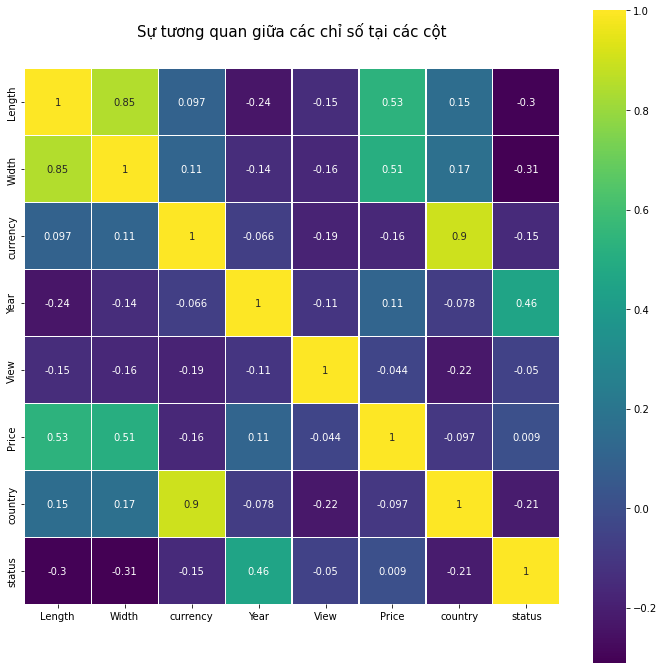

In [26]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Sự tương quan giữa các chỉ số tại các cột', y=1.05, size=15)
sns.heatmap(test_df.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Mục tiêu của chúng ta là tìm được các chỉ số có sự tương quan giữa View và các chỉ số thuộc các cột còn lại.
Các chỉ số thể hiện sự tương quan với View là:
1. Price(-0.23) -> Có thể View tăng nếu Price giảm
2. Country(-0.22): -> Có thể là những nước không sự dụng thuộc nhóm euro còn lại
3. Year(-0.13) -> Có thể View tăng nếu số năm giảm.
4. Currency (-0.18) -->Có thể View tăng nếu như không sự dụng đồng tiền thuộc nhóm euro.

Chúng ta cũng nhận ra rằng: Currency và Country có sự tương quan vô cùng lớn, cần phải xem *xét*

#Xây dựng và lựa chọn mô hình dự đoán
Chạy nhiều mô hình model để tìm ra model nào có kết quả chính xác nhất.

Nếu kết quả của mô hình vượt qua 50%, thì mô hình sẽ được nhận.

In [27]:
#Chuẩn bị dữ liệu đẻ huấn luyện mô hình
X = test_df.drop("View", axis=1)
y = test_df["View"]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [28]:
X_train.head(10)

,Length,Width,currency,Year,Price,country,status
4405,13,4,3,2013,369000,3.0,0
2400,9,3,3,2020,215127,3.0,2
8674,7,2,3,2011,33900,3.0,0
6345,9,2,3,2020,106850,3.0,2
4162,15,4,1,2012,419950,1.0,0
5713,8,2,3,2013,152000,3.0,0
6070,13,3,3,2001,125000,1.0,0
3945,23,5,3,2005,599000,3.0,0
3256,22,5,1,2016,1950000,3.0,0
5837,9,2,3,2019,144900,3.0,2


In [29]:
#LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.53

In [30]:
#DecisionTreeClassifier
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, y_train)  
Y_pred = decision_tree.predict(X_test)  
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree


95.25

In [31]:
#KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, y_train)  
Y_pred = knn.predict(X_test)  
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

33.25

In [32]:
#LinearSVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
acc_linear_svc


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


0.04

In [33]:
#Perceptron
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, y_train)

Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)
acc_perceptron


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


0.55

In [34]:
#GaussianNB
gaussian = GaussianNB() 
gaussian.fit(X_train, y_train)  
Y_pred = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian


3.89

In [35]:
#SGDClassifier
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)

sgd.score(X_train, y_train)

acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd


0.02

In [36]:
#RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)


In [37]:
#DataFrame tổng hợp kết quả của mô hình dự đoán
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
95.25,Random Forest
95.25,Decision Tree
33.25,KNN
3.89,Naive Bayes
0.55,Perceptron
0.53,Logistic Regression
0.04,Support Vector Machines
0.02,Stochastic Gradient Decent


In [54]:
#Check kiểm tra sự tương quan giữa dự đoán và kết quả thật tế
Y_pred = decision_tree.predict(X_test)
test_df1 = pd.DataFrame(y_test, columns=['View'])
test_df1 =test_df1.reset_index()
test_df1['result'] = pd.DataFrame(Y_pred)


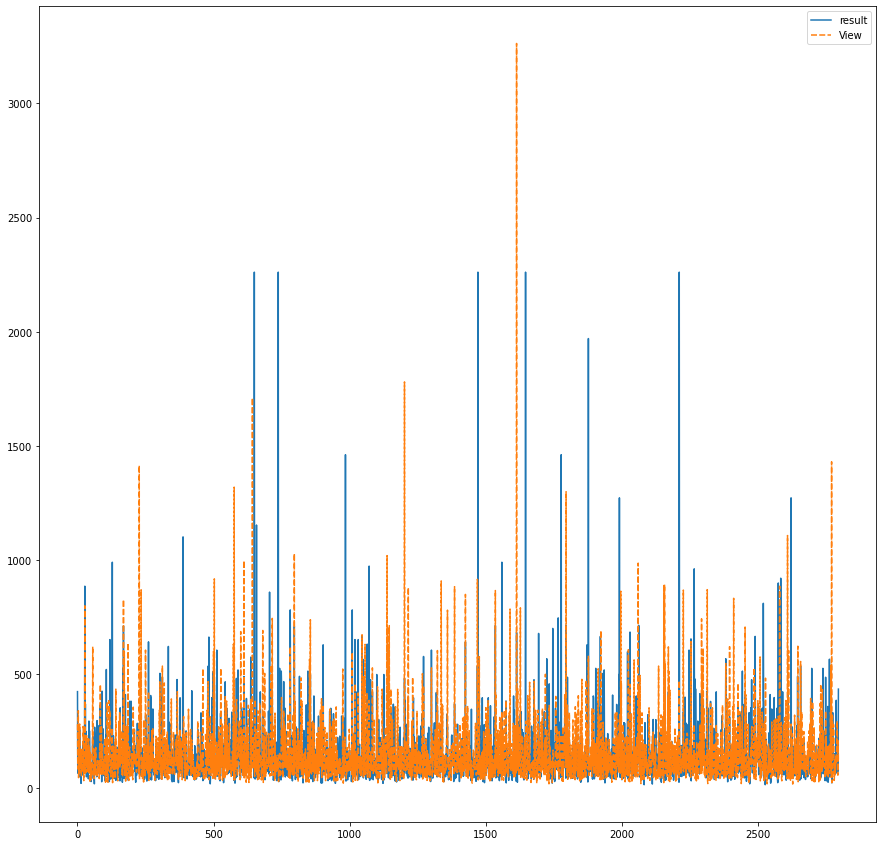

In [74]:
plt.figure(figsize=(15,15))
sns.lineplot(data=test_df1[['result','View']])

# Kết luận
1. Mô hình được lựa chọn là Random Forest và Decision Tree với kết quả vượt qua mức yêu cầu là 50% -> Không cần phải sự dụng cột Material và Manufacturer.
2. Các cột có thể bỏ đi mà không làm ảnh hưởng đến lượt view là: phần Engine trong cột Type, Material và Manufacturer.